<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Capstone Project: 2.0 Modelling - Gender Classification

> Authors: Pius Yee

##### In this Notebook 2.0, I will proceed to build the model for Gender classification.
---

## Table of Contents ##

### Notebook 2.0 Modelling - Gender Classification ###

#### 1. Importing images for model training

#### 2. Setting up the models

[2.1 Keras CNN (without pre-trained model)](#2.1-Keras-CNN-(without-pre-trained-model))

[2.2 VGGFace (Transfer learning from Pre-trained model)](#2.2-VGGFace-(Transfer-learning-from-Pre-trained-model))

[2.3 ResNet50 (Transfer learning from Pre-trained model)](#2.3-ResNet50-(Transfer-learning-from-Pre-trained-model))

[2.4 Evaluation of base models](#2.4-Evaluation-of-base-models)

#### 3. Hyperparameter tuning - VGGFace

[3. Hyperparameter tuning - VGGFace](#3.-Hyperparameter-tuning---VGGFace)

#### 4. Model evaluation after tuning - VGGFace

[4. Model evaluation after tuning - VGGFace](#4.-Model-evaluation-after-tuning---VGGFace)

[4.1 Metrics](#4.1-Metrics)

[4.2 Confusion Matrix](#4.2-Confusion-Matrix)

[4.3 ROC AUC](#4.3-ROC-AUC)

[4.4 Validation image with true and false prediction](#4.4-Validation-image-with-true-and-false-prediction)


---

### Import libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.image import imread
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Dropout, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras
from keras_vggface.vggface import VGGFace
from keras.applications.resnet import ResNet50

from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, auc, classification_report


## 1. Importing images for model training

In [2]:
# Import dataframe from the previous notebook

df_main = pd.read_csv("../datasets/df_main.csv",index_col=0)
df_main.head()

,filename,age,gender,race,age_range
0,9_1_2_20161219204347420.jpg.chip.jpg,9,Female,Asian,0-10
1,36_0_1_20170117163203851.jpg.chip.jpg,36,Male,Black,31-40
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120
3,26_1_0_20170116171048641.jpg.chip.jpg,26,Female,White,21-30
4,1_1_2_20161219154612988.jpg.chip.jpg,1,Female,Asian,0-10


##### For the train-test splitting of data, I will manually create a new column in the dataframe for the train and test data instead of using the train-test split library. The reason for this approach is that I will use the flow-from-dataframe method to import images, making it easier to manually split the train and test data.

In [3]:
# Manually create a train-test split column in the dataframe, with 80% for train and 20% for test.
np.random.seed(39)
df_main['train_test'] = np.random.choice([0, 1], size=len(df_main), p=[0.8,0.2],)
df_main

,filename,age,gender,race,age_range,train_test
0,9_1_2_20161219204347420.jpg.chip.jpg,9,Female,Asian,0-10,0
1,36_0_1_20170117163203851.jpg.chip.jpg,36,Male,Black,31-40,0
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120,1
3,26_1_0_20170116171048641.jpg.chip.jpg,26,Female,White,21-30,0
4,1_1_2_20161219154612988.jpg.chip.jpg,1,Female,Asian,0-10,0
...,...,...,...,...,...,...
23702,35_0_0_20170117155112202.jpg.chip.jpg,35,Male,White,31-40,0
23703,52_0_3_20170119200211340.jpg.chip.jpg,52,Male,Indian,51-60,0
23704,26_0_1_20170116010114628.jpg.chip.jpg,26,Male,Black,21-30,1
23705,28_0_1_20170117015458481.jpg.chip.jpg,28,Male,Black,21-30,1


##### For importing the images, I will use ImageDataGenerator from Keras. It not only help to rescale the training images, but also do augmentation for the images.

##### In this case, I used the following augmentations:

- `width_shift_range=0.2:` Randomly shifts the image horizontally along the width by up to 20% of the total width, enhancing model robustness to object position variations.

- `height_shift_range=0.2:` Randomly shifts the image vertically along the height by up to 20% of the total height, similar to the width shift but in the vertical direction.

- `shear_range=0.2:` Applies a shear transformation, slanting the image along one axis, helping simulate perspective changes.

- `zoom_range=0.2:` Randomly zooms the image in or out by up to 20%, making the model more resilient to changes in the object's apparent size.

- `horizontal_flip=True:` Randomly flips the image horizontally (like looking in a mirror), helping prevent the model from developing biases based on left/right orientation.

- `fill_mode='nearest':` Specifies how to fill in newly created pixels at the image edges after transformations (shifts, shears, etc.), using the nearest pixel value to preserve the image's overall structure.

In [4]:
# Create an ImageDataGenerator for training images (with augmentation)
datagen_train = ImageDataGenerator(   # for train data
        rescale=1.0/255.0,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# Create an ImageDataGenerator for validation images (without augmentation)
datagen_val = ImageDataGenerator(   # for validation data
        rescale=1.0/255.0)

##### Import the images with the newly created ImageDataGenerator

In [5]:
# Set up data flow using flow_from_dataframe
train_data = datagen_train.flow_from_dataframe(
    dataframe=df_main[df_main.train_test == 0],
    directory='../datasets/utkface',
    x_col='filename',
    y_col='gender',
    target_size=(224,224),
    class_mode='binary')  

val_data = datagen_val.flow_from_dataframe(
    dataframe=df_main[df_main.train_test == 1],
    directory='../datasets/utkface',
    x_col='filename',
    y_col='gender',
    target_size=(224,224),
    class_mode='binary') 

Found 18981 validated image filenames belonging to 2 classes.
Found 4726 validated image filenames belonging to 2 classes.


##### There are 2 classes for the data - Female and Male.

In [6]:
# check the classes for imported data
train_data.class_indices

{'Female': 0, 'Male': 1}

## 2. Setting up the models

##### For the models, I will use 3 different models as baselines to determine which one yields the best result. I will then select the best-performing model for further tuning.

##### The 3 models are:
- Keras CNN (without pre-trained model)
- VGGFace
- ResNet

### 2.1 Keras CNN (without pre-trained model)

##### Setting up the model architecture

In [7]:
model_cnn = Sequential()

# Add a convolutional layer to the instantiated empty model.
# Conv2D for 2-D convolution on image
model_cnn.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 3)))

# EVERY convolution layer is followed by a pooling layer.
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# more layers
model_cnn.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Add some fully connected layers once we have 1-D vector from 'Flatten()'
# Keeping it simpler this time (1 dense layer lighter, no 32-node layer here vs previous configuration)
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid')) # Output layer

# show the summary
model_cnn.summary()

2024-05-04 18:36:46.848977: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-04 18:36:46.849061: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-05-04 18:36:46.849083: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-05-04 18:36:46.849529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-04 18:36:46.850018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 128)               1

In [12]:
# Compile model.
opt = Adam(learning_rate=0.001) # create Adam optimizer with 1e-3 learning rate
model_cnn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) # use accuracy as the metric since it represents both true positives and true negatives

In [13]:
# Fit model on training data (fit model and save results to history)
history_cnn = model_cnn.fit(train_data, # train_data created using ImageDataGenerator class for model training
                        batch_size=64,
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation
                        epochs=5,
                       )

Epoch 1/5
594/594 [==============================] - 277s 454ms/step - loss: 0.6535 - accuracy: 0.6342 - val_loss: 0.5646 - val_accuracy: 0.7040
Epoch 2/5
594/594 [==============================] - 268s 450ms/step - loss: 0.5965 - accuracy: 0.6823 - val_loss: 0.5454 - val_accuracy: 0.7234
Epoch 3/5
594/594 [==============================] - 267s 450ms/step - loss: 0.5671 - accuracy: 0.7074 - val_loss: 0.5328 - val_accuracy: 0.7404
Epoch 4/5
594/594 [==============================] - 266s 448ms/step - loss: 0.5373 - accuracy: 0.7267 - val_loss: 0.4893 - val_accuracy: 0.7611
Epoch 5/5
594/594 [==============================] - 265s 446ms/step - loss: 0.5292 - accuracy: 0.7356 - val_loss: 0.4686 - val_accuracy: 0.7687


##### The results are as follows:-

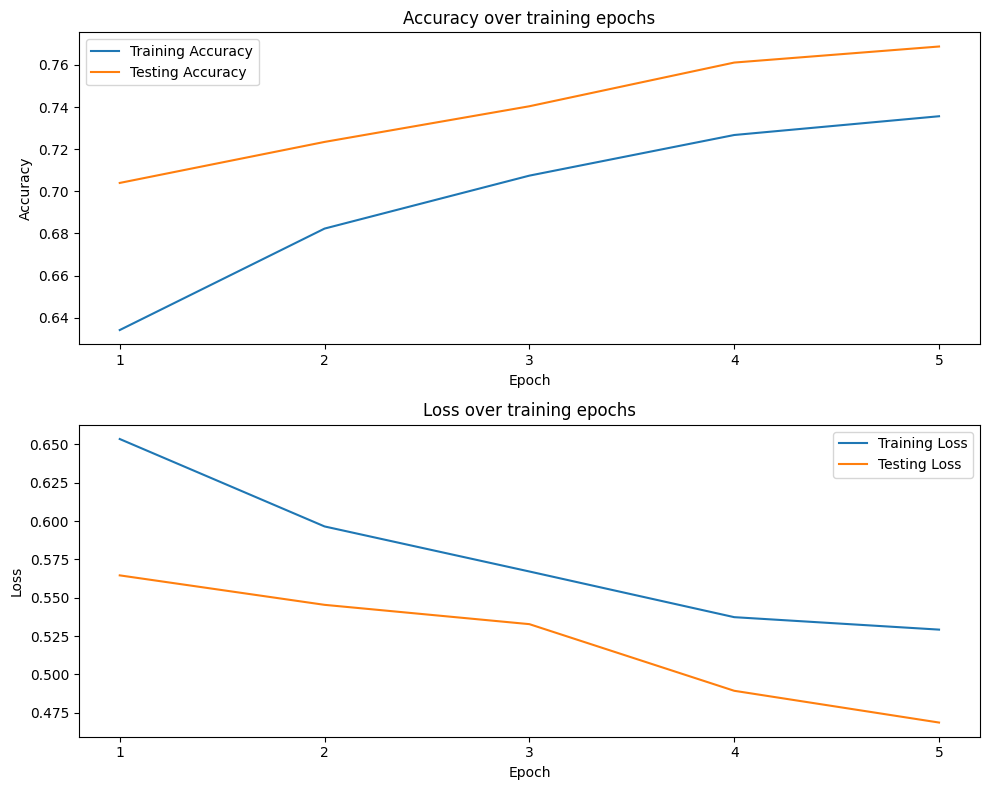

In [38]:
# Check out the train loss and test loss over epochs.
train_loss_cnn = history_cnn.history['loss']
test_loss_cnn = history_cnn.history['val_loss']
train_acc_cnn = history_cnn.history['accuracy']
test_acc_cnn = history_cnn.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_cnn, label='Training Accuracy')
axes[0].plot(test_acc_cnn, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_cnn)), np.arange(1, len(test_acc_cnn)+1))

axes[1].plot(train_loss_cnn, label='Training Loss')
axes[1].plot(test_loss_cnn, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_cnn)), np.arange(1, len(test_acc_cnn)+1))


# Set title
plt.tight_layout()
plt.show()

##### Based on the result above, accuracy increasing and loss decreasing with the training epochs. The validation accuracy is around 0.77 at the last epoch.

### 2.2 VGGFace (Transfer learning from Pre-trained model)

##### Import the pre-trained model

In [9]:
# Import the desired pre-trained transfer learning model: VGGFace
pre_trained_vgg = VGGFace(model='vgg16', include_top=False, input_shape=(224,224,3))

# Freeze the model so we don't accidentally change the pre-trained model parameters during dense layer gradient descent
for layer in pre_trained_vgg.layers:
  layer.trainable = False

##### Setting up the model architecture

In [10]:
model_vgg = Sequential()

# Add the pretrained mdoel
model_vgg.add(pre_trained_vgg)

# Flatten the pre-trained output
model_vgg.add(Flatten())

# Add dense layers
model_vgg.add(Dense(128, activation='relu'))
model_vgg.add(Dense(64, activation='relu'))
model_vgg.add(Dense(1, activation='sigmoid')) # Output layer

# show the summary
model_vgg.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 128)               3211392   
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 17,934,401
Trainable params: 3,219,713
Non-trainable params: 14,714,688
_________________________________________________________________


In [18]:
# Compile model.
opt = Adam(learning_rate=0.001) # create Adam optimizer with 1e-3 learning rate
model_vgg.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) # use accuracy as the metric since it represents both true positives and true negatives

In [19]:
# Fit model on training data (fit model and save results to history)
history_vgg = model_vgg.fit(train_data, # train_data created using ImageDataGenerator class for model training
                        batch_size=64,
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation
                        epochs=5,
                       )

Epoch 1/5
594/594 [==============================] - 342s 562ms/step - loss: 0.2605 - accuracy: 0.8833 - val_loss: 0.1938 - val_accuracy: 0.9209
Epoch 2/5
594/594 [==============================] - 317s 532ms/step - loss: 0.2223 - accuracy: 0.9052 - val_loss: 0.1959 - val_accuracy: 0.9187
Epoch 3/5
594/594 [==============================] - 316s 532ms/step - loss: 0.2126 - accuracy: 0.9087 - val_loss: 0.1961 - val_accuracy: 0.9226
Epoch 4/5
594/594 [==============================] - 301s 507ms/step - loss: 0.2081 - accuracy: 0.9126 - val_loss: 0.1929 - val_accuracy: 0.9207
Epoch 5/5
594/594 [==============================] - 300s 505ms/step - loss: 0.2033 - accuracy: 0.9132 - val_loss: 0.1892 - val_accuracy: 0.9264


##### The results are as follows:-

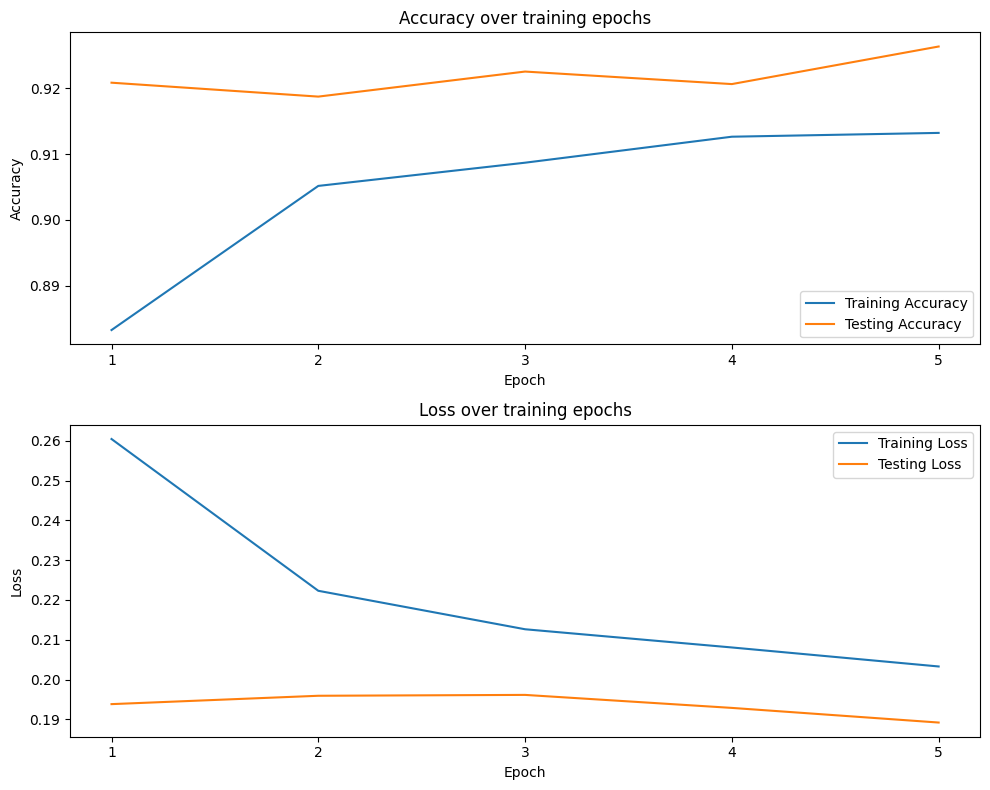

In [39]:
# Check out the train loss and test loss over epochs.
train_loss_vgg = history_vgg.history['loss']
test_loss_vgg = history_vgg.history['val_loss']
train_acc_vgg = history_vgg.history['accuracy']
test_acc_vgg = history_vgg.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_vgg, label='Training Accuracy')
axes[0].plot(test_acc_vgg, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg)), np.arange(1, len(test_acc_vgg)+1))

axes[1].plot(train_loss_vgg, label='Training Loss')
axes[1].plot(test_loss_vgg, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg)), np.arange(1, len(test_acc_vgg)+1))

# Set title
plt.tight_layout()
plt.show()

##### The acccuracy is much better than the previous CNN model. It is ended at 0.92.

### 2.3 ResNet50 (Transfer learning from Pre-trained model)

##### Import the pre-trained model

In [22]:
# Import the desired pre-trained model
pre_trained_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the model so it does not accidentally change the pre-trained model parameters during dense layer gradient descent
for layer in pre_trained_resnet.layers:
  layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


##### Setting  up the model architecture

In [23]:
model_resnet = Sequential()

# Add the pretrained mdoel
model_resnet.add(pre_trained_resnet)

# Flatten the pre-trained output
model_resnet.add(Flatten())

# Add dense layers
model_resnet.add(Dense(128, activation='relu'))
model_resnet.add(Dense(64, activation='relu'))
model_resnet.add(Dense(1, activation='sigmoid')) # Output layer

# show the summary
model_resnet.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               12845184  
                                                                 
 dense_7 (Dense)             (None, 64)                8256      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 36,441,217
Trainable params: 12,853,505
Non-trainable params: 23,587,712
_________________________________________________________________


In [24]:
# Compile model.
opt = Adam(learning_rate=0.001) # create Adam optimizer with 1e-3 learning rate
model_resnet.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) # use accuracy as the metric since it represents both true positives and true negatives

In [25]:
# Fit model on training data (fit model and save results to history)
history_resnet = model_resnet.fit(train_data, # train_data created using ImageDataGenerator class for model training
                        batch_size=64,
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation
                        epochs=5,
                       )

Epoch 1/5
594/594 [==============================] - 302s 498ms/step - loss: 0.7479 - accuracy: 0.5252 - val_loss: 0.6709 - val_accuracy: 0.5476
Epoch 2/5
594/594 [==============================] - 289s 486ms/step - loss: 0.6974 - accuracy: 0.5316 - val_loss: 0.6916 - val_accuracy: 0.5294
Epoch 3/5
594/594 [==============================] - 288s 485ms/step - loss: 0.6925 - accuracy: 0.5204 - val_loss: 0.6915 - val_accuracy: 0.5294
Epoch 4/5
594/594 [==============================] - 293s 492ms/step - loss: 0.6923 - accuracy: 0.5213 - val_loss: 0.6913 - val_accuracy: 0.5303
Epoch 5/5
594/594 [==============================] - 289s 487ms/step - loss: 0.6922 - accuracy: 0.5233 - val_loss: 0.6914 - val_accuracy: 0.5294


##### The results are as follows:-

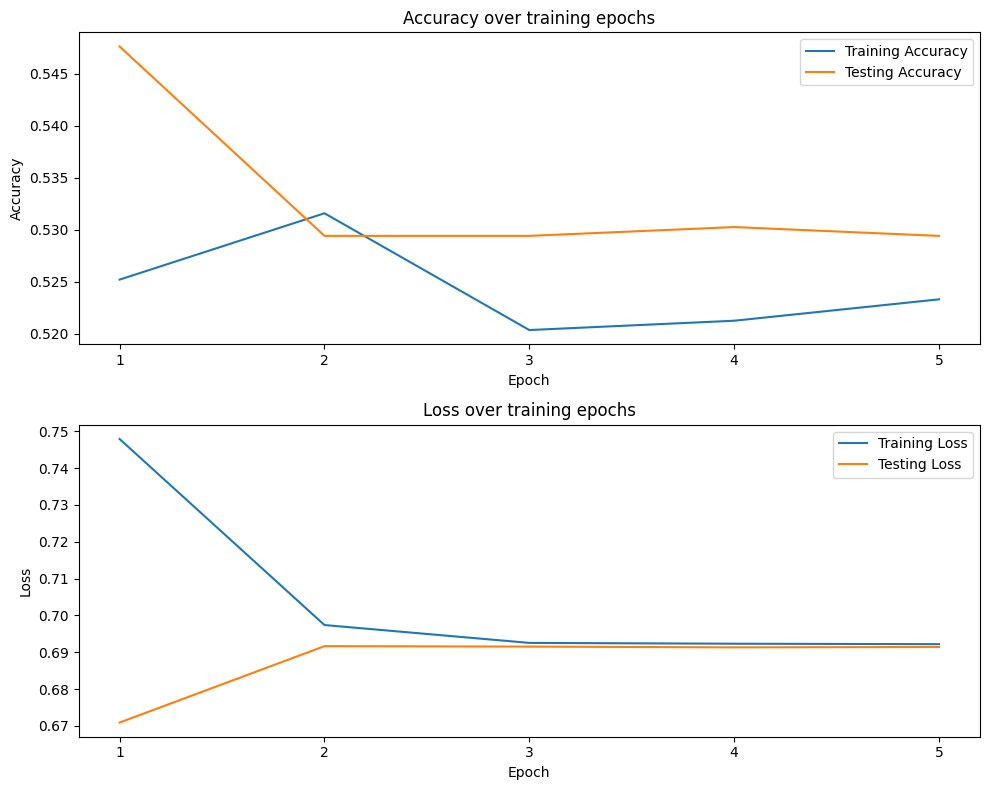

In [40]:
# Check out the train loss and test loss over epochs.
train_loss_resnet = history_resnet.history['loss']
test_loss_resnet = history_resnet.history['val_loss']
train_acc_resnet = history_resnet.history['accuracy']
test_acc_resnet = history_resnet.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_resnet, label='Training Accuracy')
axes[0].plot(test_acc_resnet, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

axes[1].plot(train_loss_resnet, label='Training Loss')
axes[1].plot(test_loss_resnet, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

# Set title
plt.tight_layout()
plt.show()

##### The accuracy is way worse than the previous 2 models, which is 0.53.

### 2.4 Evaluation of base models

##### The combined results for baseline models are:

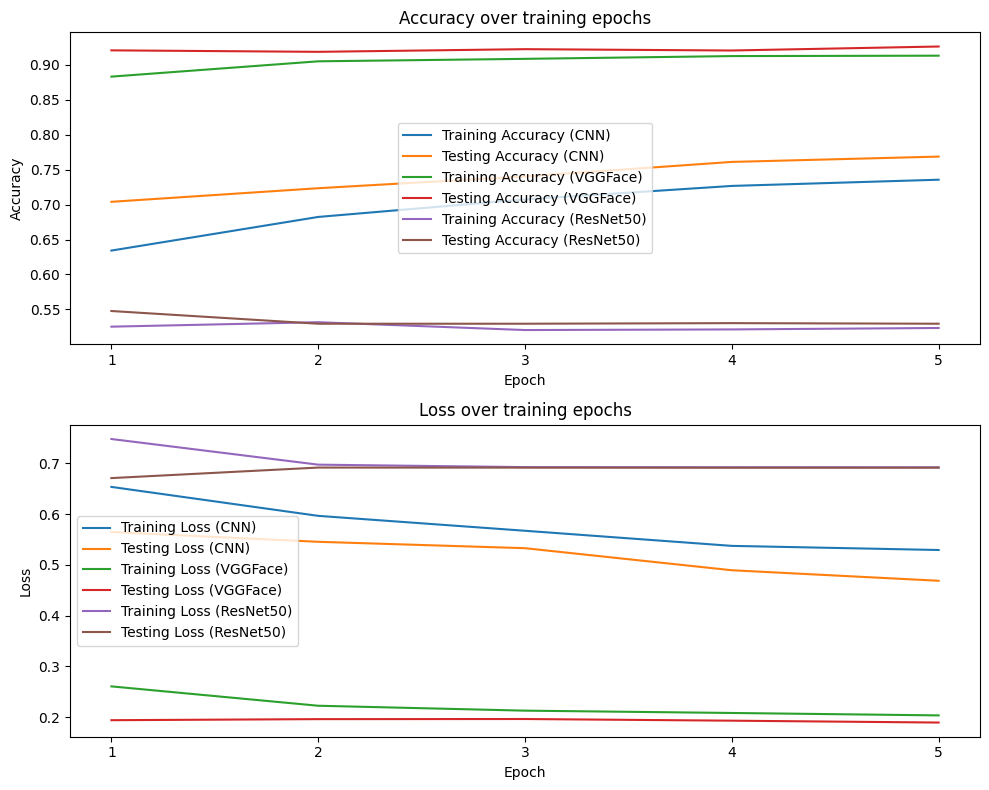

In [45]:
# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
# Accuracy
axes[0].plot(train_acc_cnn, label='Training Accuracy (CNN)')
axes[0].plot(test_acc_cnn, label='Testing Accuracy (CNN)')
axes[0].plot(train_acc_vgg, label='Training Accuracy (VGGFace)')
axes[0].plot(test_acc_vgg, label='Testing Accuracy (VGGFace)')
axes[0].plot(train_acc_resnet, label='Training Accuracy (ResNet50)')
axes[0].plot(test_acc_resnet, label='Testing Accuracy (ResNet50)')

axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

# Loss
axes[1].plot(train_loss_cnn, label='Training Loss (CNN)')
axes[1].plot(test_loss_cnn, label='Testing Loss (CNN)')
axes[1].plot(train_loss_vgg, label='Training Loss (VGGFace)')
axes[1].plot(test_loss_vgg, label='Testing Loss (VGGFace)')
axes[1].plot(train_loss_resnet, label='Training Loss (ResNet50)')
axes[1].plot(test_loss_resnet, label='Testing Loss (ResNet50)')

axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')

axes[1].set_xticks(np.arange(len(test_acc_resnet)), np.arange(1, len(test_acc_resnet)+1))

# Set title
plt.tight_layout()
plt.show()

| Model         | Train Accuracy |  Validation Accuracy |
|:-------------:|:--------:|:--------:|
| CNN            |  0.7356    |  0.7687  |
| VGGFace |  0.9132    |  0.9264  |
| ResNet 50       |  0.5233    |  0.5294  |

##### Based on the results above, VGGFace performed the best in both accuracy and loss. It has the highest accuracy and lowest loss.

##### In view of this, it is chosen to further tuning.

## 3. Hyperparameter tuning - VGGFace

##### I tried many different parameters to tune the VGGFace model for better performance, including different optimizer, epochs, layers, regularisation and etc.

##### The following is the best performance:

- Changed the layers after pre-trained model to dense 128 and 64.
- Use early stopping to prevent a machine learning model from overfitting by stopping training when its performance on a validation set stops improving.
- Added regularisation techniques like Batch Normalization and Dropout

In [13]:
# Create our FNN model architecture
model_vgg_opt = Sequential()

# Add the pre-trained model (VGGFace)
model_vgg_opt.add(pre_trained_vgg)

# Flatten the VGG16 output
model_vgg_opt.add(Flatten())

# Add dense layers with batch normalization before activation functions and dropout
model_vgg_opt.add(Dense(128))
model_vgg_opt.add(BatchNormalization())
model_vgg_opt.add(Activation('relu'))
model_vgg_opt.add(Dropout(0.5))  # Add dropout with rate 0.5

model_vgg_opt.add(Dense(64))
model_vgg_opt.add(BatchNormalization())
model_vgg_opt.add(Activation('relu'))
model_vgg_opt.add(Dropout(0.5))  # Add dropout with rate 0.5

# Output layer for binary classification (gender)
model_vgg_opt.add(Dense(1, activation='sigmoid'))

model_vgg_opt.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vggface_vgg16 (Functional)  (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_7 (Dense)             (None, 128)               3211392   
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 128)               0         
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                      

##### Adding early stop to the model training:-

In [14]:
# Instantiating EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0,
                           patience=5,
                           mode='auto')

In [15]:
# Compile the model (same as what we've been doing before)
opt = Adam(learning_rate=0.0001) # specify Adam optimizer
model_vgg_opt.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy']) # use accuracy as the metric since it represents both true positives and true negatives

In [16]:
# Fit model on training data (fit model and save results to history)
history_vgg_opt = model_vgg_opt.fit(train_data, # train_data created using ImageDataGenerator class for model training (X, y split internally)
                        batch_size=32, # hyperparameter to tune
                        validation_data=val_data, # val_data created using ImageDataGenerator class for model validation (X, y split internally)
                        epochs=20, # generally less than 5 is sufficient when using transfer learning!
                        callbacks=[early_stop] # early stop
                        )

Epoch 1/20


2024-05-04 18:39:54.403892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


594/594 [==============================] - 441s 738ms/step - loss: 0.3725 - accuracy: 0.8307 - val_loss: 0.2276 - val_accuracy: 0.9141
Epoch 2/20
594/594 [==============================] - 550s 926ms/step - loss: 0.2778 - accuracy: 0.8806 - val_loss: 0.2012 - val_accuracy: 0.9240
Epoch 3/20
594/594 [==============================] - 520s 875ms/step - loss: 0.2594 - accuracy: 0.8883 - val_loss: 0.1959 - val_accuracy: 0.9204
Epoch 4/20
594/594 [==============================] - 509s 856ms/step - loss: 0.2496 - accuracy: 0.8939 - val_loss: 0.1894 - val_accuracy: 0.9251
Epoch 5/20
594/594 [==============================] - 491s 827ms/step - loss: 0.2509 - accuracy: 0.8929 - val_loss: 0.1858 - val_accuracy: 0.9257
Epoch 6/20
594/594 [==============================] - 494s 832ms/step - loss: 0.2412 - accuracy: 0.8959 - val_loss: 0.1907 - val_accuracy: 0.9266
Epoch 7/20
594/594 [==============================] - 522s 879ms/step - loss: 0.2371 - accuracy: 0.8997 - val_loss: 0.1855 - val_accura

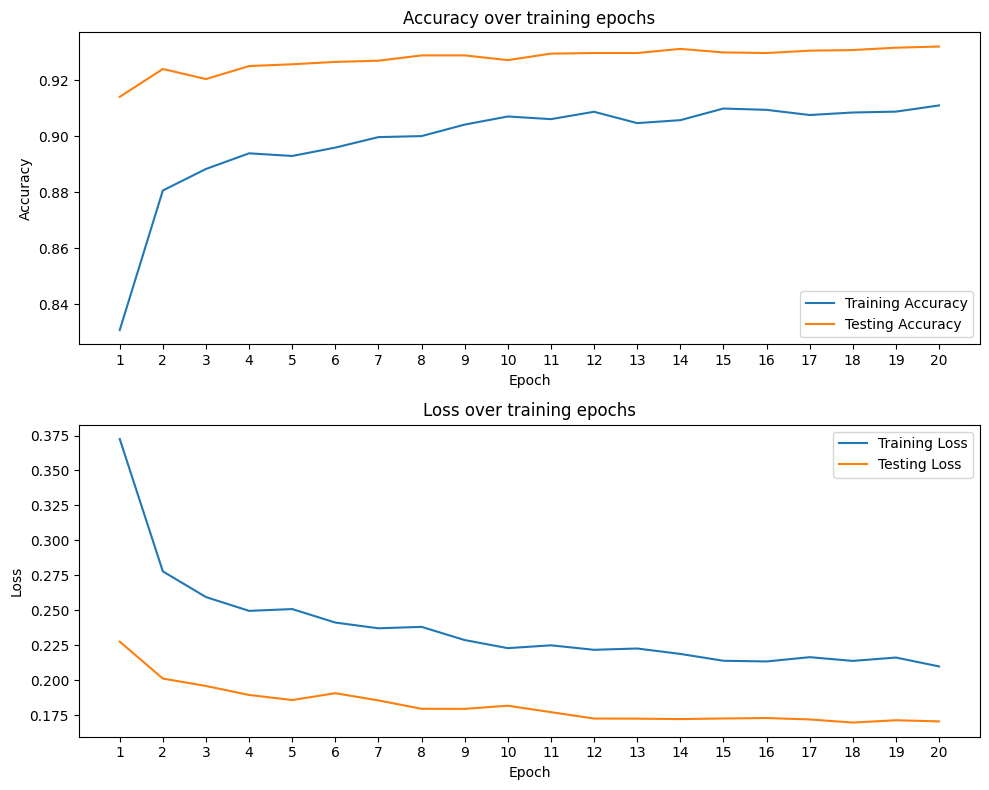

In [17]:
# Check out the train loss and test loss over epochs.
train_loss_vgg_opt = history_vgg_opt.history['loss']
test_loss_vgg_opt = history_vgg_opt.history['val_loss']
train_acc_vgg_opt = history_vgg_opt.history['accuracy']
test_acc_vgg_opt = history_vgg_opt.history['val_accuracy']

# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
axes[0].plot(train_acc_vgg_opt, label='Training Accuracy')
axes[0].plot(test_acc_vgg_opt, label='Testing Accuracy')
axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

axes[1].plot(train_loss_vgg_opt, label='Training Loss')
axes[1].plot(test_loss_vgg_opt, label='Testing Loss')
axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

# Set title
plt.tight_layout()
plt.show()

##### Based on the result above, the performance is improved after tuning. I will compare the result below.

---

##### Save the models before proceeding to the next section

In [19]:
# Export the final model as keras format.
keras.models.save_model(model_vgg_opt,"../models/model_gender.keras")

In [7]:
# load the exported keras file.
gender_model = tf.keras.models.load_model('../models/model_gender.keras')

## 4. Model evaluation after tuning - VGGFace

##### To evaluate the result, I added the prediction result to dataframe.

In [8]:
# create a new dataframe for testing
df_test = df_main[df_main.train_test == 1]

##### The output 0 is female and 1 is male:

In [9]:
# check the classes for imported data
train_data.class_indices

{'Female': 0, 'Male': 1}

##### Creating a function to read the model output -  >0.5 is male and <0.5 is female.

In [10]:
# Create a function to make prediction based on the final model

def predict_gender_series(filename):
    # read the images
    image = cv2.imread(os.path.join("../datasets/utkface", filename))
    image = cv2.resize(image, (224,224))
    image = np.expand_dims(image, axis=0) / 255.0

    # Predict gender
    gender = gender_model.predict(image)
    return "Male" if gender > 0.5 else "Female"


##### Adding the predicted results for validation data to a new dataframe

In [12]:
# Adding prediction to dataframe
df_test['gender_predict'] = df_test['filename'].apply(predict_gender_series)

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 23ms/step


/var/folders/p4/69_wbmy1275g6vc8jw1vvhf00000gn/T/ipykernel_4901/1602480448.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test['gender_predict'] = df_test['filename'].apply(predict_gender_series)


In [13]:
df_test.head()

,filename,age,gender,race,age_range,train_test,gender_predict
2,86_1_0_20170120225751953.jpg.chip.jpg,86,Female,White,71-120,1,Female
9,36_0_3_20170119180245724.jpg.chip.jpg,36,Male,Indian,31-40,1,Female
10,58_0_2_20170116193704928.jpg.chip.jpg,58,Male,Asian,51-60,1,Male
11,6_1_0_20170114024512634.jpg.chip.jpg,6,Female,White,0-10,1,Female
12,35_1_2_20170116185947151.jpg.chip.jpg,35,Female,Asian,31-40,1,Female


##### The prediction from the final model is added to the dataframe as "gender_predict".

### 4.1 Metrics

Evaluate all the models based on metrics.

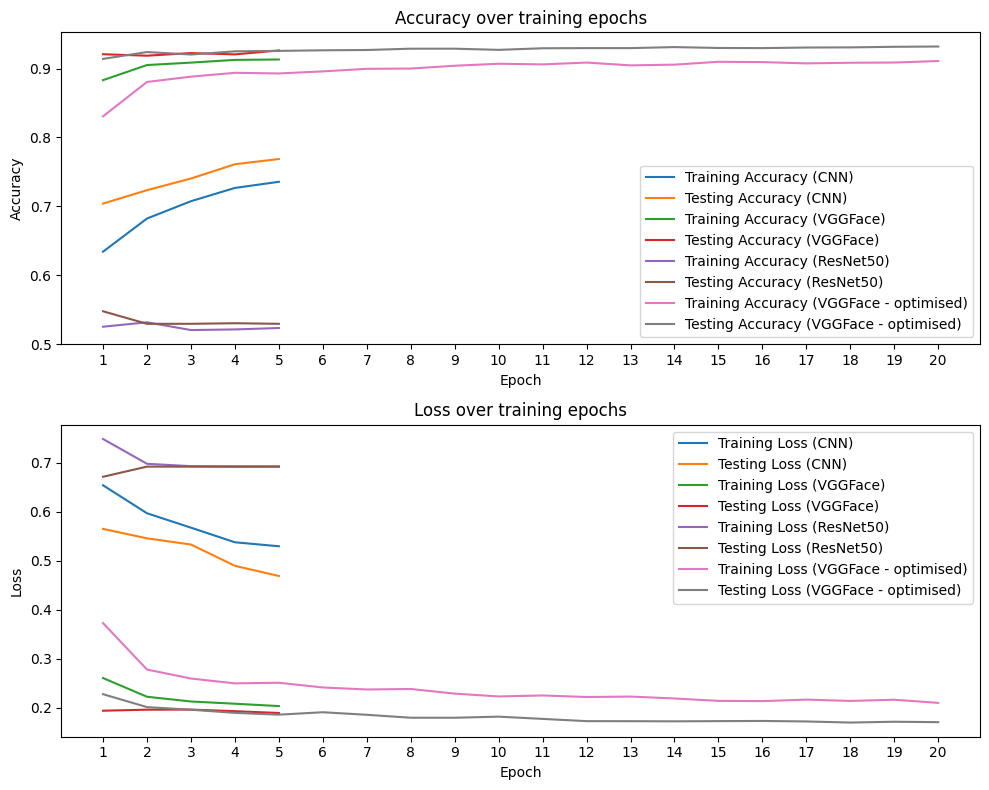

In [ ]:
# Set figure size.
fig, axes = plt.subplots(nrows=2, figsize=(10,8))

# Generate line plot of training, testing loss over epochs.
# Accuracy
axes[0].plot(train_acc_cnn, label='Training Accuracy (CNN)')
axes[0].plot(test_acc_cnn, label='Testing Accuracy (CNN)')
axes[0].plot(train_acc_vgg, label='Training Accuracy (VGGFace)')
axes[0].plot(test_acc_vgg, label='Testing Accuracy (VGGFace)')
axes[0].plot(train_acc_resnet, label='Training Accuracy (ResNet50)')
axes[0].plot(test_acc_resnet, label='Testing Accuracy (ResNet50)')
axes[0].plot(train_acc_vgg_opt, label='Training Accuracy (VGGFace - optimised)')
axes[0].plot(test_acc_vgg_opt, label='Testing Accuracy (VGGFace - optimised)')

axes[0].set_title("Accuracy over training epochs")
axes[0].legend();
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

# Loss
axes[1].plot(train_loss_cnn, label='Training Loss (CNN)')
axes[1].plot(test_loss_cnn, label='Testing Loss (CNN)')
axes[1].plot(train_loss_vgg, label='Training Loss (VGGFace)')
axes[1].plot(test_loss_vgg, label='Testing Loss (VGGFace)')
axes[1].plot(train_loss_resnet, label='Training Loss (ResNet50)')
axes[1].plot(test_loss_resnet, label='Testing Loss (ResNet50)')
axes[1].plot(train_loss_vgg_opt, label='Training Loss (VGGFace - optimised)')
axes[1].plot(test_loss_vgg_opt, label='Testing Loss (VGGFace - optimised)')

axes[1].set_title("Loss over training epochs")
axes[1].legend();
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_xticks(np.arange(len(test_acc_vgg_opt)), np.arange(1, len(test_acc_vgg_opt)+1))

# Set title 
plt.tight_layout()
plt.show()

| Model         | Train Accuracy |  Validation Accuracy |
|:-------------:|:--------:|:--------:|
| CNN            |  0.7356    |  0.7687  |
| VGGFace |  0.9132    |  0.9264  |
| ResNet 50       |  0.5233    |  0.5294  |
| VGGFace (after tuning)       |  0.9110    |  0.9321  |

##### Based on the plot above, the tuned VGGFace model demonstrates the best performance with the highest accuracy and lowest loss.

##### Extending the training from 5 to 20 epochs further improved the model's performance.

---

##### We further evaluate the final VGGFace model with other metrics.

In [14]:
# Classification Report (including precision, recall)
print(classification_report(df_test.gender, df_test.gender_predict))

              precision    recall  f1-score   support

      Female       0.94      0.92      0.93      2224
        Male       0.93      0.95      0.94      2502

    accuracy                           0.93      4726
   macro avg       0.93      0.93      0.93      4726
weighted avg       0.93      0.93      0.93      4726



##### Based on the metrics above, the model performed very well. Both the macro and weighted averages are around 0.93. 

##### The table below explains the meanings of accuracy, sensitivity, and precision.

<img src="https://miro.medium.com/v2/format:webp/0*-oGC3SE8sPCPdmxs.jpg">

### 4.2 Confusion Matrix

##### Plotting the confusion matrix for validation data below:

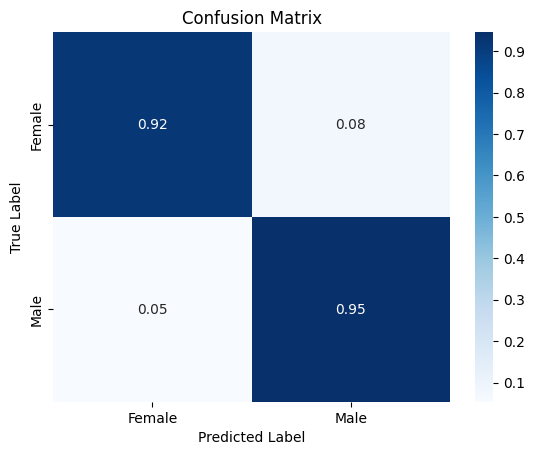

In [15]:
# Calculate the confusion matrix
cm = confusion_matrix(df_test.gender, df_test.gender_predict)

# Convert the confusion matrix to percentage (True label over prediction label)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a heatmap using Seaborn 
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=train_data.class_indices.keys(), yticklabels=train_data.class_indices.keys()) 

# Labels, title, and ticks
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (% over total true label)')
plt.show()

##### Similar to the confusion matrix, the model's predictions are very good. The majority of the results are predicted correctly for both males and females.

### 4.3 ROC AUC

AUC: 0.9321043165467625


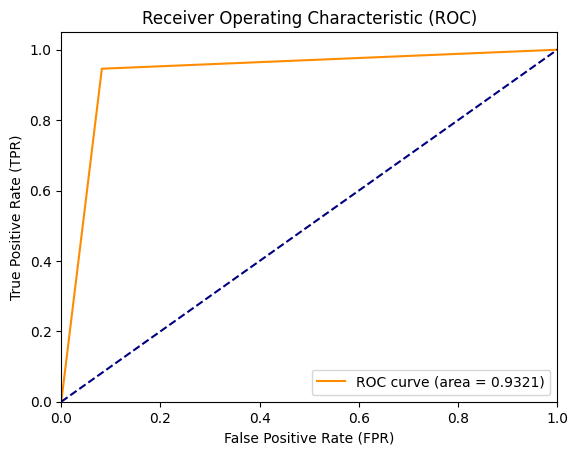

In [ ]:
label_mapping = {'Female': 0, 'Male': 1}
y_true = df_test['gender'].map(label_mapping)
y_predicted = df_test['gender_predict'].map(label_mapping)

fpr, tpr, thresholds = roc_curve(y_true, y_predicted)
auc = roc_auc_score(y_true, y_predicted)
print('AUC:', auc)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--') # Random classifier diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

##### The ROC-AUC score of 0.93 indicates excellent performance. A score of 0.93 suggests that the model has a high ability to distinguish between the positive and negative classes, with a minimal false positive rate and a high true positive rate. 

##### In practical terms, this means that the model is making accurate predictions the majority of the time, making it a strong performer for the task at hand.

### 4.4 Validation image with true and false prediction

##### To gain visual insight into the predictions, refer to the random sample of true and false prediction images below.

##### - Correct prediction

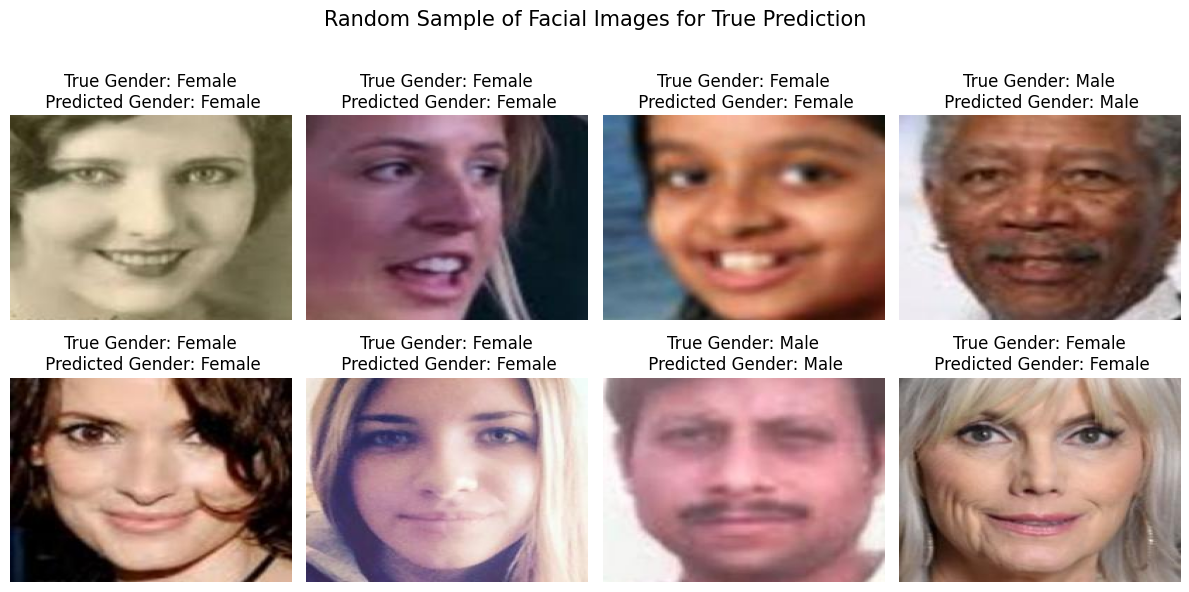

In [ ]:
# set a random seed
np.random.seed(42)

# define a function to get the label
# for example, filename "32_0_1_20170113183229559.jpg" is age 32, male and black

def extract_info_from_filename(filename):
    age, gender, race, _ = filename.split("_")
    return age, gender, race

# set a subplot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))


#randonly choose 8 images from correct prediction
img_list = []
for _ in range(8):
    img_list.append(np.random.choice(df_test[df_test.gender == df_test.gender_predict].filename))

# Load the image
nrow = 0
ncol = 0

for num, img in enumerate(img_list):
    image = imread(os.path.join("../datasets/utkface",img))

    # Display the image
    axes[nrow, ncol].imshow(image, cmap='gray', aspect='auto')
    axes[nrow, ncol].set_title(f"True Gender: {df_test.loc[df_test.filename == img].gender.values[0]}\n Predicted Gender: {df_test.loc[df_test.filename == img].gender_predict.values[0]}")
    axes[nrow, ncol].axis('off')

    ncol += 1
    if ncol == 4:
        nrow += 1
        ncol = 0

plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.suptitle("Random Sample of Facial Images for True Prediction",fontsize=15)
plt.show()

##### - False prediction

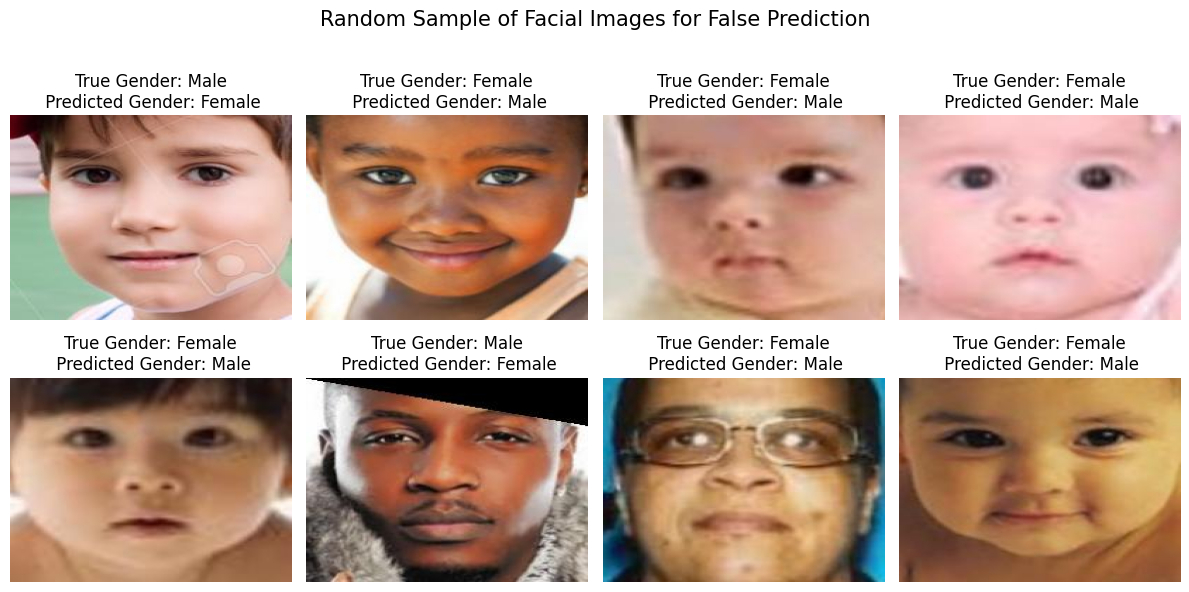

In [ ]:
# define a function to get the label
# for example, filename "32_0_1_20170113183229559.jpg" is age 32, male and black

def extract_info_from_filename(filename):
    age, gender, race, _ = filename.split("_")
    return age, gender, race

# set a subplot
fig, axes = plt.subplots(2, 4, figsize=(12, 6))


#randonly choose 8 images from correct prediction
img_list = []
for _ in range(8):
    img_list.append(np.random.choice(df_test[df_test.gender != df_test.gender_predict].filename))

# Load the image
nrow = 0
ncol = 0

for num, img in enumerate(img_list):
    image = imread(os.path.join("../datasets/utkface",img))

    # Display the image
    axes[nrow, ncol].imshow(image, cmap='gray', aspect='auto')
    axes[nrow, ncol].set_title(f"True Gender: {df_test.loc[df_test.filename == img].gender.values[0]}\n Predicted Gender: {df_test.loc[df_test.filename == img].gender_predict.values[0]}")
    axes[nrow, ncol].axis('off')

    ncol += 1
    if ncol == 4:
        nrow += 1
        ncol = 0

plt.tight_layout()
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.suptitle("Random Sample of Facial Images for False Prediction",fontsize=15)
plt.show()

---

##### Misclassifed gender based on age group:
##### Based on the random samples of false predictions above, I found that detecting the gender of small children appears to be more challenging. Therefore, I conducted further analysis to examine the proportion of false predictions based on age groups.

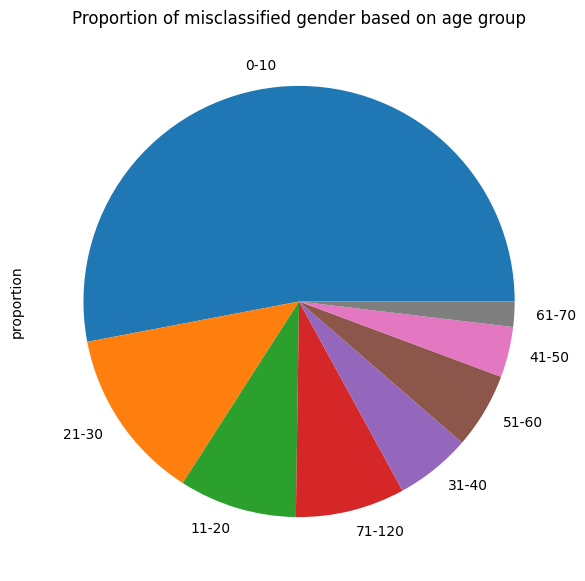

In [ ]:
df_test[df_test.gender != df_test.gender_predict].age_range.value_counts(normalize=True).plot(kind='pie',figsize=(7,7));
plt.title('Proportion of misclassified gender based on age group');
plt.tight_layout;

##### The earlier hypothesis is correct. The age range '0-10' comprises more than half of the misclassified gender population.

##### Misclassifed gender based on race:

##### As for the misclassified gender based on race, White is the highest propotion, followed by Asian and Indian.

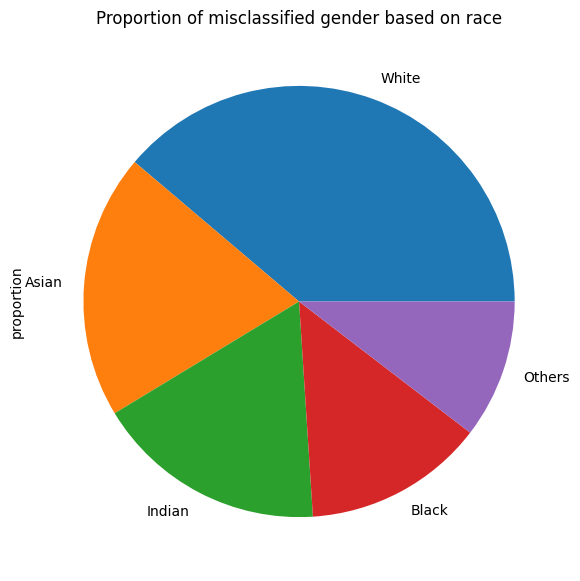

In [ ]:
df_test[df_test.gender != df_test.gender_predict].race.value_counts(normalize=True).plot(kind='pie',figsize=(7,7));
plt.title('Proportion of misclassified gender based on race');
plt.tight_layout;

---

##### Next, I will move to Notebook 2.1 to build a model for race classification.